<a href="https://colab.research.google.com/github/Theodin28/test-git/blob/master/Lab07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Artificial Neural Networks

In this lab, we will learn how to set up some Neural Networks to do image classification. 

We will use both the sklearn package and the Keras framework.

# Setup

It is good practice to do your standard imports at the start of your notebook.

You can also do specific imports just at the points they are required.

In [0]:
import sklearn
import tensorflow as tf
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Google Colab

Colaboratory, or "Colab" for short, is an IDE/python notebook that enables you to write and execute Python in your browser, with 
- no configuration required
- access to GPUs
- sharing of notebooks

First we download our data into Colab. You will need a Google account to perform this step.

##The Hand Gesture Dataset

The image dataset we will work with today is a collection of infrared images of hand gestures. You can read more about it [here](https://sites.google.com/site/leapgestrecog/home)

In [0]:
###Downloading hand gesture dataset
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Google Colab provides downloadable links to data from Google drive.
# You need to know the Google id of the data, which we provide for you.

#Downloading hand gesture dataset (modified from https://www.kaggle.com/gti-upm/leapgestrecog/version/1)
id = '1EVCibsWq1vq5R8ARLL6b5_qCieDmX6XS'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('x_test.npy')

id = '1ENkRtJvEiYDV5mIPxxGAbdW8uyrNGpfi'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('x_train.npy')

id='1EWwUYJOHu158m_TEm1dmnY9vmSTN3g38'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('y_test.npy')

id='1Eaus0CR6OFcJzornbT27PpXkBBWOMIJI'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('y_train.npy')


Look at the shape of the data. What do the four dimensions represent?

In [0]:
###load and scale the dataset
x_train=np.load('x_train.npy').astype('float32')/255
x_test=np.load('x_test.npy').astype('float32')/255
y_train=np.load('y_train.npy')
y_test=np.load('y_test.npy')
print(x_train.shape)
_,height,width,_=x_train.shape


(14000, 120, 320, 1)


In [0]:
print(x_train[0][0][0])

[0.01568628]



Have a peep at the training data by looking at the first image and its label.



label: 7


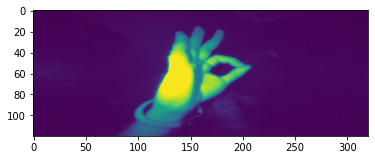

In [0]:

plt.imshow(x_train.reshape(x_train.shape[0],height,width)[0])
print('label:',y_train[0])


##Meaning of labels in this dataset:

There are ten types of images in this dataset, with labels as follows:

0---Thumb down;    1---Palm (Horizontal);    2---L;    3---Fist (Horizontal);    4---Fist (Vertical);    5---Thumbs up;    6---Index;    7---OK;    8---Palm (Vertical);    9---C






---



# Perceptrons

A perceptron is one of the simplest neural networks. It directly models a neuron in a brain, with inputs, an activation function, and output(s). It has learnable weights and biases that can be trained via backpropagation of a loss calculated at each iteration.

We are going to train a perceptron on our dataset using Sklearn.

Always have a look at the user guide for the model you are using:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html

In [0]:
from sklearn.linear_model import Perceptron

np.random.seed(42)

###To shorten the training process, we will randomly pick 1000 images each for\
###both training and testing from the original dataset. 
###You can try to use the whole dataset in the excercise.
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
chosen_train = index[0:1000]
index = np.arange(x_test.shape[0])
np.random.shuffle(index)
chosen_test = index[0:1000]


###flatten and indexing
X = x_train.reshape(x_train.shape[0],-1)[chosen_train]

print(X.shape)  #120*320

y = y_train[chosen_train]


###make an instance of the Perceptron model and train it
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)
print('perceptron trained')


###predict and evaluate on 1000 samples from test set
x_test_ = x_test.reshape(x_test.shape[0],-1)[chosen_test]
y_test_ = y_test[chosen_test]

y_pred_per = per_clf.predict(x_test_)
comparison_per = np.where(y_pred_per==y_test_,1,0)
print('first 100 results: 1=correct')
print(comparison_per[0:100])
accuracy_per = np.sum(comparison_per)/x_test_.shape[0]
print(f"test accuracy: {(accuracy_per*100):.2f}%")

(1000, 38400)
perceptron trained
first 100 results: 1=correct
[0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
test accuracy: 88.40%


# Activation functions

A neuron in a neural network applies an activation function to the sum of its inputs, in order to calculate its output. An activation function is monotonically increasing (so that the output can be activated for all values of the weighted input above some value) and piecewise differentiable (this is important to enable backpropagation).

Let's plot some well known activation functions and their derivatives.

In [0]:
###a plot function that applies activations to an input z in
def plot_activation_derivative(**kwargs):
      
  z = np.linspace(-5, 5, 200)
  plt.figure(figsize=(11,4))
  plt.subplot(121)
  for i in kwargs:
    act_func=kwargs.get(i)
    plt.plot(z, act_func(z), linewidth=2, label=act_func.__name__)
  
  plt.plot(z,np.zeros(z.shape),'k',linewidth=1)
  plt.plot(np.zeros(z.shape),z,'k',linewidth=1)
  plt.grid(True)
  plt.legend(loc="best", fontsize=12)
  plt.title("Activation function", fontsize=14)
  plt.xlabel('input', fontsize=12)
  plt.ylabel('activation output',fontsize=12)
  plt.axis([-5, 5, -1.5, 1.5])
  

  plt.subplot(122)
  for i in kwargs:
    act_func=kwargs.get(i)
    plt.plot(z, derivative(act_func, z), linewidth=2, label=act_func.__name__)

  plt.plot(z,np.zeros(z.shape),'k',linewidth=1)
  plt.plot(np.zeros(z.shape),z,'k',linewidth=1)
  plt.grid(True)
  plt.legend(loc="best", fontsize=12)
  plt.title("Derivatives", fontsize=14)
  plt.xlabel('input', fontsize=12)
  plt.ylabel('derivative',fontsize=12)
  plt.axis([-5, 5, -0.2, 1.2])

  plt.show()

In [0]:
###define different activation functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def leakyrelu(z,alpha=0.05):
    return np.maximum(alpha*z,z)

def tanh(z):
    return np.tanh(z)

def elu(z,alpha=0.05):
    return np.where(z>=0,z,alpha*(np.exp(z)-1))

def maxout(z,w1=1.1,b1=0.5,w2=0.1,b2=-0.3):
    return np.where((w1*z+b1)>(w2*z+b2),(w1*z+b1),(w2*z+b2))

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

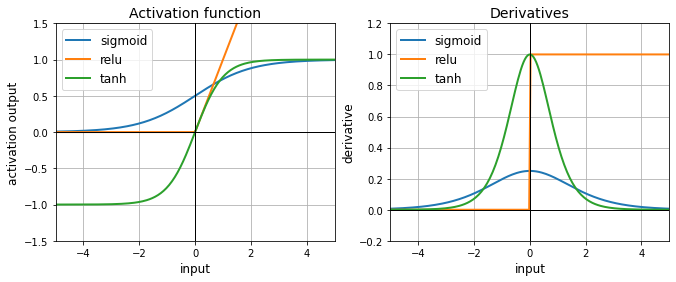

In [0]:
# Compare the defined activation functions with input between(-5,5) and their estimated derivative
# Put activation functions defined above as plot function arguments 
plot_activation_derivative(f1=sigmoid, f2=relu, f3=tanh)

##Task

Please add the other activation functions to the plot.



# Building an Image Classifier

Next we are going to use the Keras framework to build an image classifier for our dataset. Keras is a user friendly front end for TensorFlow. 

The TensorFlow library is a library especially designed for writing neural networks. It represents the network in memory as a graph and uses a datatype called tensors.

First let's import TensorFlow and Keras.

In [0]:
import tensorflow as tf
from tensorflow import keras

Clear any existing TensorFlow graph from memory and set random seeds.

In [0]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Define a Keras Sequential model with an input layer and three dense layers. What is a dense layer?

Again, please look at the user guides:

https://keras.io/getting-started/sequential-model-guide/

https://keras.io/layers/core/ (for the Dense layer)

The hidden layers will have relu activation in their neurons.


In [0]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[height*width],batch_size=100),
    keras.layers.Dense(300, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(300, activation="relu", kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation="softmax")
])

The final layer has a size of 10 and a softmax activation. What are we trying to achieve with this layer?

We can look at the model in various ways: list the layers (not too useful), print a summary (useful for seeing the number of trainable parameters and output dimensions), or plot a simple visualisation the model.

In [0]:
model.layers

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (100, 300)                11520300  
_________________________________________________________________
dense_1 (Dense)              (100, 300)                90300     
_________________________________________________________________
dense_2 (Dense)              (100, 10)                 3010      
Total params: 11,613,610
Trainable params: 11,613,610
Non-trainable params: 0
_________________________________________________________________


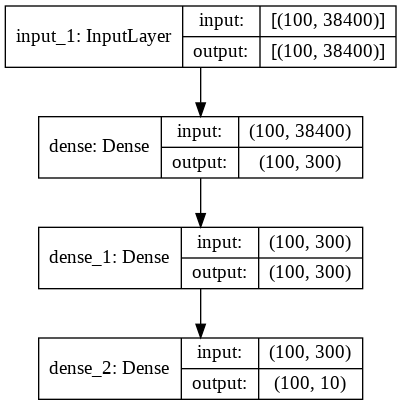

In [0]:
keras.utils.plot_model(model, "my_hand_gestures_model.png", show_shapes=True)

We can name layers as variables, which is a useful shorthand for looking at their properties later on:

In [0]:
hidden1 = model.layers[1]
hidden1.name

'dense_1'

In [0]:
model.get_layer(hidden1.name) is hidden1

True

Let's look at the weights and biases pre-training:

In [0]:
weights, biases = hidden1.get_weights()

What are these weights (how were they initialised)?

In [0]:
weights

array([[ 7.81799387e-03, -7.99118280e-02,  3.50985862e-02, ...,
         5.25717027e-02, -3.69381979e-02,  8.97064060e-02],
       [ 2.24733949e-02, -5.93330935e-02,  1.81510057e-02, ...,
         1.15057826e-01, -5.78481406e-02,  1.31418183e-01],
       [-8.14247727e-02,  9.57798883e-02, -1.71356127e-02, ...,
        -9.86292735e-02,  1.66069567e-02, -7.32357102e-03],
       ...,
       [ 2.98689008e-02, -3.78734569e-07, -2.25347150e-02, ...,
         1.07668243e-01,  7.23628998e-02, -1.77466005e-01],
       [ 3.43462564e-02, -6.67541171e-04, -4.45313938e-02, ...,
         9.93826985e-02,  2.95017958e-02,  1.03460930e-01],
       [-1.02380805e-01,  9.27029029e-02,  7.63449669e-02, ...,
        -8.06867033e-02,  9.29508805e-02,  1.46796674e-01]], dtype=float32)

Does the shape of the weights matrix for hidden1 make sense to you?

In [0]:
weights.shape

(300, 300)

Let's look at the biases in hidden1. Why are they all zero?

In [0]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [0]:
biases.shape

(300,)

Next, let's set up an optimizer and a loss function. What kind of input does a categorical cross entropy loss function expect?

Hint: check https://keras.io/losses/

In [0]:
opt = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
###data preparation for Keras model
x_train_k = X
x_test_k = x_test_
y_train_k = keras.utils.to_categorical(y, 10).astype('int32')
y_test_k = keras.utils.to_categorical(y_test_, 10).astype('int32')

Now fit the model. We will run 20 epochs. An epoch is a single coverage of all the training samples. There are 1000 training samples and the batch size is 100 so in each epoch there will be 10 batches. We pass the test set as a validation set. It is not used in training but after each epoch we will check the performance of the circuit on the validation data.

In [0]:
history = model.fit(x_train_k, y_train_k, epochs=20,
                    validation_data=(x_test_k, y_test_k),batch_size=100)

Epoch 1/20
10/10 [==============================] - 2s 166ms/step - loss: 2.3167 - accuracy: 0.1060 - val_loss: 2.2686 - val_accuracy: 0.1420
Epoch 2/20
10/10 [==============================] - 1s 149ms/step - loss: 2.2262 - accuracy: 0.1840 - val_loss: 2.2016 - val_accuracy: 0.2280
Epoch 3/20
10/10 [==============================] - 1s 149ms/step - loss: 2.1616 - accuracy: 0.2630 - val_loss: 2.1485 - val_accuracy: 0.2590
Epoch 4/20
10/10 [==============================] - 2s 151ms/step - loss: 2.1040 - accuracy: 0.3130 - val_loss: 2.1011 - val_accuracy: 0.3310
Epoch 5/20
10/10 [==============================] - 1s 148ms/step - loss: 2.0545 - accuracy: 0.3840 - val_loss: 2.0578 - val_accuracy: 0.3820
Epoch 6/20
10/10 [==============================] - 1s 150ms/step - loss: 2.0082 - accuracy: 0.4400 - val_loss: 2.0173 - val_accuracy: 0.4000
Epoch 7/20
10/10 [==============================] - 1s 149ms/step - loss: 1.9644 - accuracy: 0.4770 - val_loss: 1.9796 - val_accuracy: 0.4190
Epoch 

What do you observe about the results as the network learns? Do the losses monotonically decrease? Do the accuracies monotonically increase? Is the model overfitting?

We stored the progress in a variable called history, let's look at what is inside it.



In [0]:
history.params

{'epochs': 20, 'steps': 10, 'verbose': 1}

In [0]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [0]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

We can plot the losses and accuracies.

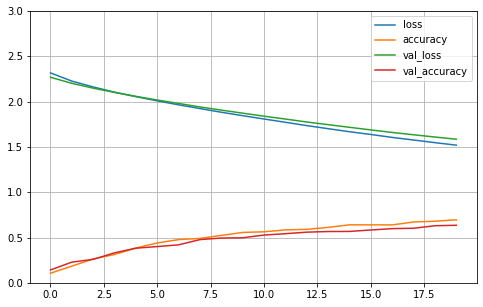

In [0]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

Let's now do a prediction on the first 50 test samples. We do an extra step after prediction - argmax. What does this step do?

In [0]:
###predict 50 data points in test set
sample_len=50
X_new = x_test_k[:sample_len]
y_proba = model.predict(X_new)
prediction = np.argmax(y_proba,axis=1)
ground_truth = np.argmax(y_test_k[:sample_len],axis=1)
print('prediction:',prediction)
print('ground_truth:',ground_truth)
count=0
for i,j in zip(prediction,ground_truth):
  if i==j:
    count+=1
print(f'Accuracy:{count*100/sample_len:.2f}%')

prediction: [3 5 0 8 5 5 0 3 3 3 8 2 3 5 4 6 1 9 3 3 8 5 1 5 3 2 3 3 0 1 3 2 1 3 5 1 9
 8 1 0 2 6 2 3 4 0 3 5 5 4]
ground_truth: [4 5 0 8 1 1 0 3 3 3 8 3 3 5 4 6 3 9 3 6 8 5 1 5 3 2 3 3 0 1 6 7 1 6 5 3 4
 8 1 0 2 6 2 3 4 7 3 5 7 4]
Accuracy:74.00%


# Functional API

Not all neural network models are simply sequential, some models may have more complex topologies. Some may have multiple inputs and/or multiple outputs. Compared to the Sequential API, the Functional API is more flexible, which allows us to build these more complex model architectures. 

We define layers of different types interrelated by their input and output. Finally incorporate them all in a single Model.

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

input_ = keras.layers.Input(shape=x_train_k.shape[1:],batch_size=100)
hidden1 = keras.layers.Dense(100, activation="relu")(input_)
hidden2 = keras.layers.Dense(38400, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(10)(concat)
output = keras.layers.Softmax()(output)
model_functional = keras.models.Model(inputs=[input_], outputs=[output])

Then look at the Model summary and plot:

In [0]:
model_functional.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(100, 38400)]       0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (100, 100)           3840100     input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (100, 38400)         3878400     dense_3[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (100, 76800)         0           input_2[0][0]                    
                                                                 dense_4[0][0]                

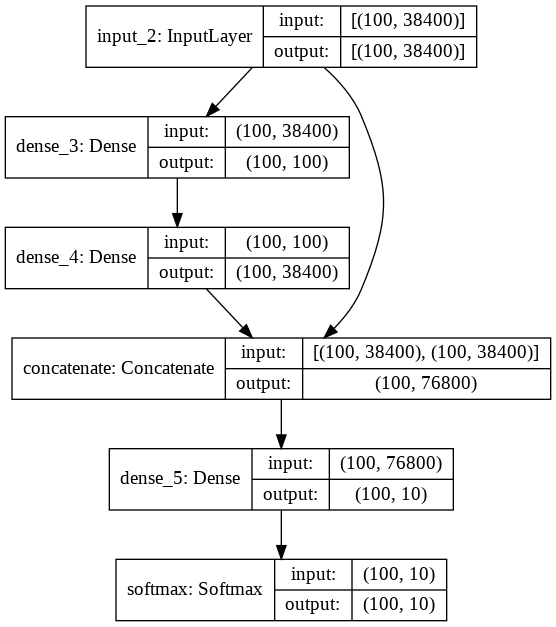

In [0]:
keras.utils.plot_model(model_functional, "my_hand_gestures_model_functional.png", show_shapes=True)

Now let's train the Model.

In [0]:
model_functional.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3),metrics=['accuracy'])
history = model_functional.fit(x_train_k, y_train_k, epochs=20,
                    validation_data=(x_test_k, y_test_k),batch_size=100)



Epoch 1/20
10/10 [==============================] - 2s 218ms/step - loss: 2.3063 - accuracy: 0.1030 - val_loss: 2.2530 - val_accuracy: 0.1520
Epoch 2/20
10/10 [==============================] - 2s 196ms/step - loss: 2.2252 - accuracy: 0.1710 - val_loss: 2.2024 - val_accuracy: 0.1660
Epoch 3/20
10/10 [==============================] - 2s 193ms/step - loss: 2.1748 - accuracy: 0.1920 - val_loss: 2.1599 - val_accuracy: 0.2140
Epoch 4/20
10/10 [==============================] - 2s 193ms/step - loss: 2.1235 - accuracy: 0.2390 - val_loss: 2.1173 - val_accuracy: 0.2850
Epoch 5/20
10/10 [==============================] - 2s 192ms/step - loss: 2.0785 - accuracy: 0.3230 - val_loss: 2.0781 - val_accuracy: 0.3060
Epoch 6/20
10/10 [==============================] - 2s 194ms/step - loss: 2.0366 - accuracy: 0.3720 - val_loss: 2.0437 - val_accuracy: 0.3170
Epoch 7/20
10/10 [==============================] - 2s 198ms/step - loss: 1.9973 - accuracy: 0.3700 - val_loss: 2.0095 - val_accuracy: 0.3610
Epoch 

The Functional model is more complicated but how do its results compare with the Sequential model after the same number of epochs?

Let's look at the first ten softmax predictions for the test set.

In [0]:
y_pred = model_functional.predict(X_new)
print(y_pred[0:10])

# Saving and Restoring

We can save models in the Colab drive. This is useful as we don't want to have to continually rerun models. Let's save our last model then restore it under a new name and check it gives the same predictions.

You can see saved models, images and downloaded data in the Files window to the left of this notebook.

In [0]:
model_functional.save("my_keras_model.h5")

In [0]:
model_functional_reloaded = keras.models.load_model("my_keras_model.h5",compile=False)

In [0]:
model_functional_reloaded.predict(X_new[0:10])

# Using Callbacks during Training

Callbacks are functions that can be applied during training with their results stored for later use. One such function is a Model Checkpoint which saves the intermediate training model with the best result for one of the metrics.

User guide: https://keras.io/callbacks/

What is the default metric for the 'save_best_only' instruction to monitor?

In [0]:
model_functional_reloaded.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3),metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model_best.h5", save_best_only=True)
history = model_functional_reloaded.fit(x_train_k, y_train_k, epochs=20,
                    validation_data=(x_test_k, y_test_k),
                    callbacks=[checkpoint_cb],batch_size=100)

EarlyStopping is another callback. What does it do?

In [0]:
model_functional_reloaded.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=1e-3),metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model_functional_reloaded.fit(x_train_k, y_train_k, epochs=20,
                    validation_data=(x_test_k, y_test_k),
                    callbacks=[early_stopping_cb],batch_size=100)

# Exercise

Please use the Keras Functional API to build and train a multilayer neural network for hand gesture recognition. Your model needs to satisfy the following: 

*   it must have at least three hidden layers; 
*   the hidden layers must use LeakyReLU as activation;
*   it must use Adam as the optimizer to train your model.

Please tune the model parameters (hidden size, alpha of LeakyReLU, learning rate) and save your best model using callback. Can you achieve 95% accuracy on the test set?

In [0]:
###Start your code from here. You can use the below variables as training \
###and test sets (You can also use the complete dataset).
x_train_k = X
x_test_k = x_test_
y_train_k = keras.utils.to_categorical(y, 10).astype('int32')
y_test_k = keras.utils.to_categorical(y_test_, 10).astype('int32')
